<a href="https://colab.research.google.com/github/HLapendery/FootballAnalysis/blob/master/LigaAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import requests as rq
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup

plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
github = "https://github.com"
github_raw = "https://raw.githubusercontent.com"
url_liga = "/statsbomb/open-data/tree/master/data/matches/11"
page = rq.get(github + url_liga)
html = BeautifulSoup(page.text,'html.parser')
seasons_links = html.find_all('a',attrs = {'title':re.compile(r"^.*\.json$")})
seasons_href = [a['href'].replace('/blob','') for a in seasons_links]



def get_seasons_data(list_seasons):
  all_seasons = []
  for s in tqdm(list_seasons):
    season = pd.read_json(github_raw + s)
    for i,match in season.iterrows():
      attributes = {
            "match_id": match['match_id'],
            "season": match['season']['season_name'],
            "home": match['home_team']['home_team_name'],
            "away": match['away_team']['away_team_name'],
            "home_score": match['home_score'],
            "away_score": match['away_score'],
            "week": match['match_week']
        }
      all_seasons.append(attributes)
            
  return pd.DataFrame(all_seasons)

In [0]:
df_seasons = get_seasons_data(seasons_href)

100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


In [0]:
df_seasons.sort_values(['season','week']).reset_index(drop = True)
nb_games = df_seasons.iloc[:,:2].groupby('season').count()
by_season_goals = df_seasons.groupby('season').sum().reset_index()
by_season_goals['games'] = nb_games.values
by_season_goals = by_season_goals.loc[:,['season','games']]
scored_home = df_seasons['home_score'][df_seasons['home']=='Barcelona'].groupby(df_seasons['season']).sum()
scored_away = scored = df_seasons['away_score'][df_seasons['away']=='Barcelona'].groupby(df_seasons['season']).sum()
conceded_home = df_seasons['away_score'][df_seasons['home']=='Barcelona'].groupby(df_seasons['season']).sum()
conceded_away = df_seasons['home_score'][df_seasons['away']=='Barcelona'].groupby(df_seasons['season']).sum()
by_season_goals['scored_home'] = scored_home.values
by_season_goals['scored_away'] = scored_away.values
by_season_goals['scored'] = by_season_goals['scored_home'] + by_season_goals['scored_away']
by_season_goals['conceded_home'] = conceded_home.values
by_season_goals['conceded_away'] = conceded_away.values
by_season_goals['conceded'] = by_season_goals['conceded_home'] + by_season_goals['conceded_away']
by_season_goals['diff'] = by_season_goals['scored'] - by_season_goals['conceded']
by_season_goals['diff/90'] = by_season_goals['diff']/by_season_goals['games']
by_season_goals = by_season_goals[['season', 'games', 'scored', 'conceded', 'diff', 'diff/90', 'scored_home', 'scored_away', 'conceded_home', 'conceded_away']]

,season,games,scored,conceded,diff,diff/90,scored_home,scored_away,conceded_home,conceded_away
0,2004/2005,7,16,2,14,2.000000,13,3,1,1
1,2005/2006,17,43,12,31,1.823529,25,18,9,3
2,2006/2007,26,55,24,31,1.192308,26,29,10,14
3,2007/2008,28,61,32,29,1.035714,37,24,8,24
4,2008/2009,31,94,29,65,2.096774,53,41,11,18
5,2009/2010,35,93,23,70,2.000000,52,41,10,13
6,2010/2011,33,86,18,68,2.060606,43,43,9,9
7,2011/2012,37,111,28,83,2.243243,70,41,10,18
8,2012/2013,32,98,38,60,1.875000,51,47,13,25
9,2013/2014,31,80,28,52,1.677419,50,30,13,15


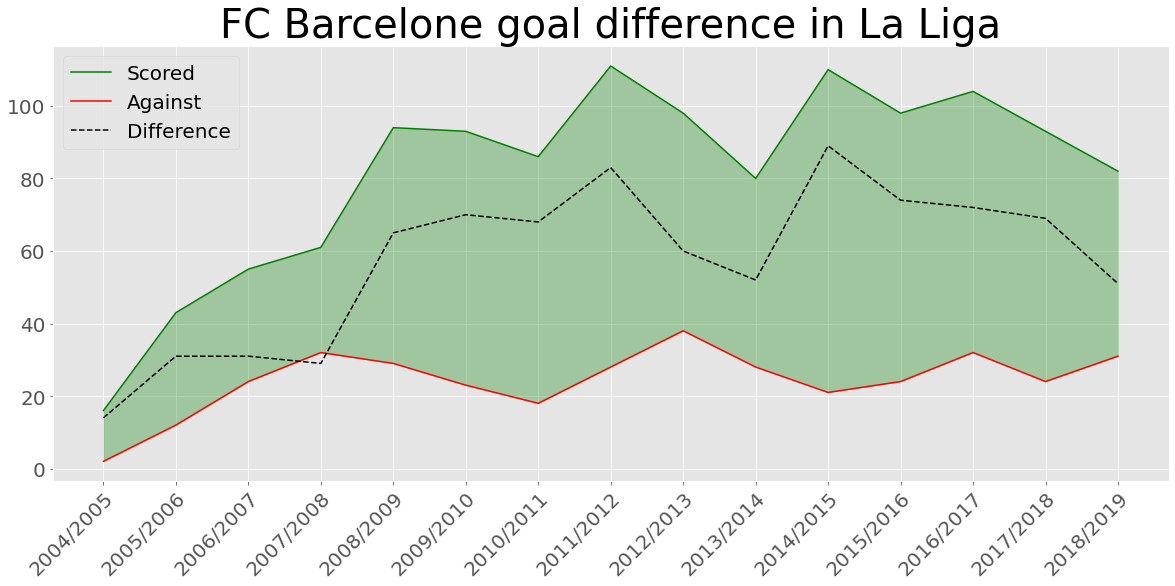

In [0]:
fig = plt.figure(figsize=(20, 8))
x = by_season_goals['season']
yh = by_season_goals['scored']
ya = by_season_goals['conceded']
plt.plot(x, yh, 'g')
plt.plot(x, ya, 'r')
plt.plot(x,yh-ya,'k--',)
plt.fill_between(x, yh, ya,where=(yh>ya), interpolate=True,color='g', alpha=0.3)
plt.fill_between(x, yh, ya,where=(yh<ya), interpolate=True,color='r', alpha=0.3)
plt.legend(['Scored','Against','Difference'],loc='upper left',fontsize=20)
plt.xticks(fontsize=20, rotation=45,  rotation_mode="anchor", ha="right",)
plt.yticks(fontsize=20)
plt.title("FC Barcelone goal difference in La Liga",fontdict = {'fontsize' : 40})
plt.show()

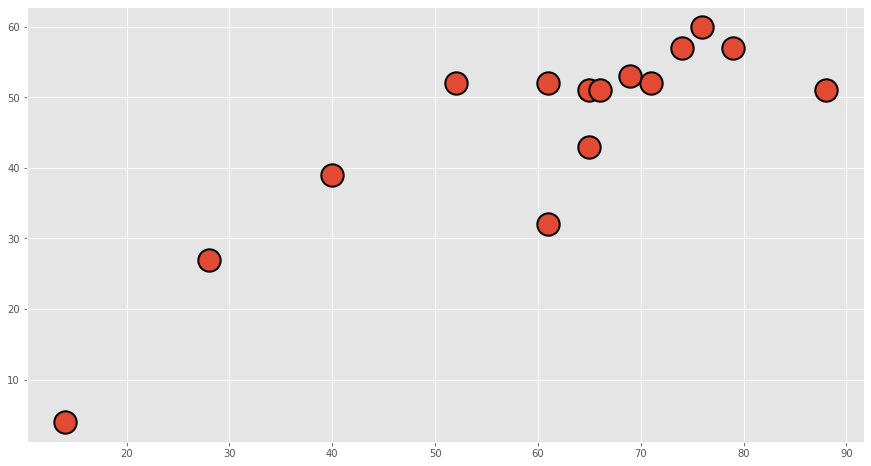

In [0]:
fig,ax = plt.subplots(figsize=(15,8))
ax.scatter(yh,ya,s=500,linewidths=2, edgecolors='black')
plt.show()